In [103]:
import numpy as np
import shtns
import pylab as py
import matplotlib
from tqdm import tqdm
import sys

sys.path.append('/data/pbarpanda/python_scripts/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import eulerian_fluxes as eflux
import netcdf_utilities as ncutil
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
from tqdm import tqdm
import glob
from PIL import Image

import numpy as np
import shtns
import pylab as py
import matplotlib
from tqdm import tqdm
import sys
import time as ti

sys.path.append('/data/pbarpanda/python_scripts/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import eulerian_fluxes as eflux
import netcdf_utilities as ncutil
from obspy.geodetics import kilometers2degrees
import momentum_advection_class as momentum_advect
from PIL import Image
import imageio
from IPython.display import Video

import matplotlib as mpl
from cycler import cycler

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'black'
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['lines.color'] = 'black'


import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'  ### This is because NOAA PSL lab computers are somehow not able to use 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "darkred", "darkorange", "pink", "white", "white","skyblue", "dodgerblue", "navy"][::-1])

def colorbar(fontsize=20):
    cbar = py.colorbar()
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(fontsize)
            
import warnings
warnings.filterwarnings('ignore')

import os
import glob

def remove_files(direc):
    files = glob.glob(direc, recursive=True)

    for f in files:
        try:
            os.remove(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

In [104]:
def eddy(X):
    return X-X.mean(axis=-1)[...,None]


def eddy(X):
    return X-X.mean(axis=-1)[...,None]

def t_eddy(X):
    return X-X.mean(axis=0)[None,...]

def locate(Y, x, gap=0.1):
    index = np.where(np.abs(Y-x) < gap)[0][0]
    return index

def locate(Y, x, gap=None):
    if gap is None:
        gap = 0.5*np.abs(np.diff(Y))[0] 
    index = np.where(np.abs(Y-x) <= gap)[0][0]
    return index

In [105]:
ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/linear_Q_forcing/

combined_data_at_forcing_region/
combined_data_at_forcing_region_constant_fluid_depth/
different_forcing_WN_same_energy/
dt_150_Q_forcing_100_forcing_y_0_Hmean_200_forcing_phase_speed_5_ms/
dt_150_Q_forcing_100_forcing_y_0_Hmean_500_forcing_phase_speed_5_ms/
dt_150_Q_forcing_10_forcing_y_0_Hmean_200_forcing_phase_speed_5_ms/
dt_150_Q_forcing_10_forcing_y_0_Hmean_500_forcing_phase_speed_5_ms/
dt_150_Q_forcing_10_forcing_y_0_Hmean_800_forcing_phase_speed_5_ms/
dt_150_Q_forcing_500_forcing_y_0_Hmean_200_forcing_phase_speed_5_ms/
dt_150_Q_forcing_500_forcing_y_0_Hmean_500_forcing_phase_speed_5_ms/


In [136]:
# switch_on_day   = 60
# switch_off_day  = switch_on_day + 120

# switch_on_time  = switch_on_day*24*3600
# switch_off_time = switch_off_day*24*3600


################ TRANSIENT FORCING ###########################
def time_time(alpha, ti):
    tt = (ti - switch_on_time)/(24*3600)
    if tt >= 0:
        transient_effect = (0.5)*(alpha**3)*((tt)**2)*np.exp(-alpha*tt)*1
    else:
        transient_effect = 0 
    return transient_effect
##############################################################


################ TRANSIENT FORCING ###########################
def time_time2(alpha, ti, switch_on_day=80, gap=200 ):
    
    switch_on_day   = switch_on_day
    switch_off_day  = switch_on_day + gap
    
    switch_on_time  = switch_on_day*24*3600
    switch_off_time = switch_off_day*24*3600

    
    tt1 = (ti - switch_on_time)/(24*3600)
    tt2 = (ti - switch_off_time)/(24*3600)

    transient_effect1 = np.tanh(tt1/alpha)
    transient_effect2 = np.tanh(tt2/alpha)
    transient_effect = (transient_effect1 - transient_effect2)/2

    return transient_effect
##############################################################


In [155]:
for alpha, switch_on_day, keep_forcing_const_for  in zip([5, 20], [45, 80], [120, 120]):
    print (alpha, switch_on_day, keep_forcing_const_for)

5 45 120
20 80 120


2879.99999909
2879.91959695


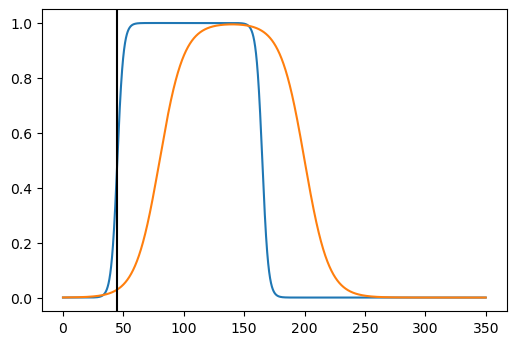

In [158]:
time = np.arange(0, 350*24*3600, 3600)
# force_envelope = np.array([time_time(0.06, ti) for ti in time])
# py.plot( time/(24*3600), force_envelope/0.01, 'r-')

alpha = 5 #, #45, 120


force_envelope = np.array([time_time2(alpha, ti, 45, 120) for ti in time])
py.plot( time/(24*3600), force_envelope, '-')
print(force_envelope.sum())

alpha = 20 #, 80, 120
force_envelope = np.array([time_time2(alpha, ti, 80, 120) for ti in time])
py.plot( time/(24*3600), force_envelope, '-')
print(force_envelope.sum())

py.axvline(45)


In [144]:
(np.max(force_envelope))

0.016240233988393523

In [ ]:
%%time

loc=0
##### This is to analyze experiments for H0 = 500
# for H0 in tqdm([500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]):
for H0 in [3000]:
    for WN in [1, 3, 5, 8, 10]:
          for Q0 in [10]:                
            source = '/data/pbarpanda/spherical_SWE/evaluate_final_budget/linear_Q_forcing/different_forcing_WN/dt_150_Q_forcing_%d_forcing_y_%d_Hmean_500_forcing_phase_speed_5_ms_forcing_WN_%d/dipole_heat_switch_on/H0_%d/'%(Q0, loc, WN, H0)
            print (source)
            if os.path.exists(source):
                vars()['Q0_%d_loc_%d_H0_%d_Hmean_500_WN_%d'%(Q0, loc, H0, WN)]           = h5saveload.load_dict_from_hdf5(source+'spatial_data.hdf5')
                vars()['Q0_%d_loc_%d_H0_%d_Hmean_500__WN_%d_equation'%(Q0, loc, H0, WN)] = h5saveload.load_dict_from_hdf5(source+'equation_data.hdf5')
            else:
                print ('Q0_%d_loc_%d_H0_%d_Hmean_500_WN_%d  does not exist yet'%(Q0, loc, H0, WN))
               

/data/pbarpanda/spherical_SWE/evaluate_final_budget/linear_Q_forcing/different_forcing_WN/dt_150_Q_forcing_10_forcing_y_0_Hmean_500_forcing_phase_speed_5_ms_forcing_WN_1/dipole_heat_switch_on/H0_3000/


In [111]:
ls  /data/pbarpanda/spherical_SWE/evaluate_final_budget/linear_Q_forcing/different_forcing_WN/

In [63]:
Q0_10_loc_0_H0_3000_Hmean_500['phi_forcing'].shape

(912, 128, 256)

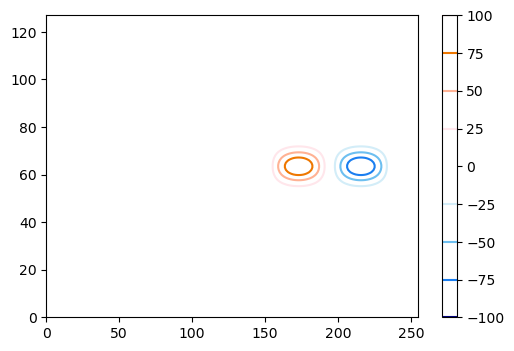

In [109]:
N=N+10
py.contour(Q0_10_loc_0_H0_3000_Hmean_500['phi_forcing'][-N,...], cmap=cmap); py.colorbar()